#Git pull & Julia environment setup

In [5]:
!git clone https://github.com/Peregriney/baseball_batting.git

Cloning into 'baseball_batting'...
remote: Enumerating objects: 334, done.
remote: Counting objects: 100% (198/198), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 334 (delta 124), reused 164 (delta 106), pack-reused 136 (from 1)
Receiving objects: 100% (334/334), 3.35 MiB | 14.18 MiB/s, done.
Resolving deltas: 100% (188/188), done.


In [6]:
%cd baseball_batting
!ls

/content/baseball_batting
agg-der.jl				    histogram-comparison.png  plotquantile.jl
agg.jl					    main.jl		      redsox_2023.csv
baseball_batting.ipynb			    mainv2.jl		      redsox_2023_lineuptop.csv
baseball_batting_v2-2.ipynb		    nl.jl		      redsox_avgs.csv
baseball-sabermetrics-deliverable-v1.ipynb  pkgimport.jl	      runtime-hist.png
config.toml				    player.jl		      sabermetriccomparison.jl
demo.jl					    player-rbi.jl	      sim.jl
derivatives.jl				    playertest.jl	      sim-player.jl
dpsim-difference.png			    plotpmf.jl


Run to download Julia and necessary packages to runtime, then proceed with rest of code.

In [7]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.8.2" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz
  export GKSwstype=100 ;

  # Install Packages
  nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
  if [ $GPU -eq 1 ]; then
    JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Installing Julia 1.8.2 on the current Colab Runtime...
2024-10-28 08:15:25 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.8/julia-1.8.2-linux-x86_64.tar.gz [135859273/135859273] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package BenchmarkTools...
Installing IJulia kernel...
[ Info: Installing julia kernelspec in /root/.local/share/jupyter/kernels/julia-1.8

Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then
jump to the 'Checking the Installation' section.


In [8]:
!julia pkgimport.jl > install_log.txt 2>&1

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import unicodedata
import re
import subprocess

def fetch_batting_orders(team_abbr, year):
    # Construct the URL based on the team abbreviation and year == batting order
    url = f'https://www.baseball-reference.com/teams/{team_abbr}/{year}-batting-orders.shtml#grid_table_46565'

    try:
        # Read all tables from the page
        tables = pd.read_html(url)

        # Assuming the desired table is the first one
        df = tables[0]
        df.iloc[:, 1:] = df.iloc[:, 1:].map(lambda x: remove_non_alpha(normalize_string(x)))

        df.to_csv('br-lineups.csv', index=False)

        return df
    except Exception as e:
        print(f"An error occurred: {e}")
        return None


def fetch_player_stats(team_abbr, year):
    # Construct the URL based on the team abbreviation and year == batting order
    url = f'https://www.baseball-reference.com/teams/{team_abbr}/{year}.shtml#team_batting'

    try:
        # Read all tables from the page
        tables = pd.read_html(url)
        #print(tables)

        # Assuming the desired table is the first one
        df = tables[0]
        #print(df)
        df['Name'] = df['Name'].apply(lambda x: remove_non_alpha(normalize_string(x)))
#        df.drop([0],axis=0,inplace=True)
        df.drop(columns=['Rk', 'Pos', 'Age','G','PA','RBI','SB','CS','BA','OBP','SLG','OPS','OPS+','TB','GDP','HBP','SH','SF','IBB'],inplace=True)
        #print(df)
        df = df[~df['AB'].str.contains('[a-zA-Z]', na=False)]
        df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)
        df = df[df['AB'] > 0]
        strikeout = pd.Series(df['SO']/df['AB'])
        hits = pd.Series(df['H']/df['AB'])
        doubles = pd.Series(df['2B']/df['AB'])
        triples = pd.Series(df['3B']/df['AB'])
        homer = pd.Series(df['HR']/df['AB'])
        singles = hits - doubles - triples - homer
        walks = pd.Series(df['BB']/df['AB'])
        otherout = 1 - walks - singles - homer - triples - doubles - strikeout
        #        df.drop(columns=['SO'], ['AB'], )
        df = df[['Name']]
        df['Strikeout'] = strikeout
        df['OO'] = otherout
        df['Walk'] = walks
        df['Single'] = singles
        df['Double'] = doubles
        df['Triple'] = triples
        df['Homer'] = homer
        df.to_csv('br-playerstats.csv', index=False)

        return df
    except Exception as e:
        print(f"An error occurred: {e}")
        return None


def normalize_string(s):
    """
    Normalize Unicode string by removing accents.
    """
    # Normalize to NFD form and remove accent marks
    return unicodedata.normalize('NFD', s).encode('ascii', 'ignore').decode('ascii')

def remove_non_alpha(s):
    """
    Remove all non-alphabetic characters from the string.
    """
    #return re.sub(r'[^a-zA-Z \-]', '', s)
    return re.sub(r'[^a-zA-Z\s-]', '', s)

def clean_names(series):
    """
    Clean the names in the pandas Series by normalizing and removing non-alphabetic characters.
    """
    # Apply normalization and removal of non-alphabetic characters
    cleaned_series = series.apply(lambda x: remove_non_alpha(normalize_string(x)))
    # Convert the cleaned Series to a list
    cleaned_list = cleaned_series.tolist()
    return cleaned_list

# Function to extract score from the first column
def extract_score(text):
    match = re.search(r'\((\d+)-(\d+)\)', text)
    if match:
        return int(match.group(1))  # Return the first number
    return None

# Function to get lineup indices based on player names
def get_lineup_indices(players_str, player_index):
    #players = players_str.split('\t')[1:]  # Skip the first element
    lineup_indices = []
    #print(players_str)
    for player in players_str:
        #last_name = player.split('-')[0].strip()  # Extract the last name
        last_name = player.rsplit('-',1)[0].strip().split(' ')[-1]
        # If the last name is found in the player_index mapping
        if last_name in player_index:
            lineup_indices.append(str(player_index[last_name]))

    #print(lineup_indices)
    return str(lineup_indices)#''.join(lineup_indices)#.ljust(9, player_index[last_name])  # Ensure it's a 9-number string


def process_output(stat_df,input_df):
      #player_list = clean_names(stat_df['Name'])
      player_list = stat_df['Name']
      #player_index = {name.split(' ')[1]: idx+1 for idx, name in enumerate(player_list)}

      player_index = {
          name.split(' ')[-2] if name.split(' ')[-1] in ["Jr","II","III","IV"] else name.split(' ')[-1]: idx + 1
          for idx, name in enumerate(player_list)
      }
      # Process the data
      output_data = []
      for _, row in input_df.iterrows():
          first_column = row[0]
          second_column = row[1:]
          score = extract_score(first_column)
          lineup_indices = get_lineup_indices(second_column, player_index)
          output_data.append([score, lineup_indices])

      # Create a DataFrame for the output
      output_df = pd.DataFrame(output_data, columns=['Score', 'Lineup'])

      # Save the output DataFrame to a new CSV file
      output_df.to_csv('output.csv', index=False)
      return


In [10]:
def extract(file_pattern):

    file_list = glob.glob(file_pattern)
    dataframes = []

    # Loop through each output file, which has empirical score, DP-score, and lineup for all games from a given team in given yr
    for file in file_list:
        print(file)
        team = file.split('_')[3]
        yr = file.split('_')[4][0:4]
        prevyr = int(yr)-1

        df = pd.read_csv(file)
        #df has columns Lineup, "Score", "Score2" already. Manually compute & add the sabermetric RC estimates.

        url = f"https://www.baseball-reference.com/teams/{team}/{yr}-batting.shtml"
        tables = pd.read_html(url)
        battingdf23 = tables[0]
        battingdf23 = battingdf23[~battingdf23['AB'].str.contains('[a-zA-Z]', na=False)].dropna()
        battingdf23.iloc[:, 3:] = battingdf23.iloc[:, 3:].astype(float)
        battingdf23['Name'] = clean_names(battingdf23['Name'])

        numrows = df.shape[0]
        teamseries = [team] * numrows
        df['team'] = teamseries

        battingdf23['saber'] = (battingdf23['H'] + battingdf23['BB']) * battingdf23['TB'] / (battingdf23['AB']+battingdf23['BB']) / battingdf23['G']


        saber23manual = []
        for i in range(numrows):
            lu = [str(re.sub(r'[^0-9]', '', x)) for x in df['Lineup'][i].replace("'","").replace("[","").replace("]","").split()]

            sumLineup22 = 0.0
            sumLineup23 = 0.0
            for playeridx in lu:

                sumLineup23 +=  (battingdf23.at[battingdf23[battingdf23['Rk'] == playeridx].index[0], 'saber'])
            saber23manual.append(sumLineup23)

        df['saber23'] = saber23manual
        dataframes.append(df)

    # Concatenate all years into a single DataFrame
    dpdf1 = pd.concat(dataframes, ignore_index=True)
    return dpdf1


# Version 2

In [ ]:
team = 'ARI'
yr = 2023



input_df = fetch_batting_orders(team,yr)
stat_df = fetch_player_stats(team,yr)
process_output(stat_df,input_df)

#!julia main.jl br-playerstats.csv 1 2 3 4 5 6 7 8 9

<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


In [ ]:
!julia mainv2.jl br-playerstats.csv 1 2 3 4 5 6 7 8 9 ARI

accepted batting lineup[1, 2, 3, 4, 5, 6, 7, 8, 9]
[19, 3, 6, 2, 11, 14, 10, 1, 25]Processing lineup: '19', '3', '6', '2', '11', '14', '10', '1', '8'
[4.212876935582244, 6.5241099977947e-310, 6.52412571061344e-310, 6.5241256357961e-310, 6.52412563697237e-310, 6.5241256357961e-310, 6.5241099977963e-310, 6.52412571061344e-310, 6.5241256357961e-310, 6.5241256372127e-310, 6.5241256357961e-310, 6.5241258428507e-310, 6.52412573333177e-310, 6.5241258428507e-310, 6.52412571083874e-310, 6.5241259097488e-310, 6.52413568280914e-310, 6.5241257106324e-310, 6.5241257106324e-310, 6.52412591769177e-310, 6.52412563692573e-310, 6.52412571083874e-310, 6.52412571061344e-310, 6.5241257106324e-310, 6.52412571061344e-310, 6.52412571061344e-310, 6.5241256357961e-310, 6.5241256357961e-310, 6.52412571061344e-310, 6.5241256357961e-310, 6.52412591769177e-310, 6.52412563692573e-310, 6.52412571083874e-310, 6.52412571061344e-310, 6.5241256357961e-310, 6.5241256357961e-310, 6.52412571061344e-310, 6.5241256357961e-310

In [ ]:
teams = ['ATL', 'BAL','BOS', 'CHC','CHW','CIN','CLE','COL','DET','HOU',
         'HOU','KCR','LAA','LAD','MIA','MIL','MIN','NYM','NYY','OAK','PHI',
         'PIT','SDP','SEA','SFG','STL','TBR','TEX','TOR','WSN'
         ]

yr = 2023


for team in teams:
  print(team)

  input_df = fetch_batting_orders(team,yr)
  stat_df = fetch_player_stats(team,yr)
  process_output(stat_df,input_df)
  input_file = 'br-playerstats.csv'
  columns_str = '1 2 3 4 5 6 7 8 9'
  command = f"julia mainv2.jl {input_file} {columns_str} {team}"
  result = subprocess.run(command, shell=True, check=True, text=True, capture_output=True)
  #!julia mainv2.jl br-playerstats.csv 1 2 3 4 5 6 7 8 9 team


BAL


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


BOS


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


CHC


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


CHW


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


CIN


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


CLE


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


COL


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


DET


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


HOU


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


HOU


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


KCR


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


LAA


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


LAD


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


MIA


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


MIL


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


MIN


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


NYM


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


NYY


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


OAK


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


PHI


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


PIT


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


SDP


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


SEA


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


SFG


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


STL


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


TBR


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


TEX


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


TOR


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


WSN


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


In [ ]:
!julia mainv2.jl br-playerstats.csv 1 2 3 4 5 6 7 8 9 ARI

accepted batting lineup[1, 2, 3, 4, 5, 6, 7, 8, 9]
['19', '3', '6', '2', '11', '14', '10', '1', '8']
[19, 3, 6, 2, 11, 14, 10, 1, 25]Processing lineup: '19', '3', '6', '2', '11', '14', '10', '1', '8'
[4.212876935582244, 6.8413802382477e-310, 6.8413802382493e-310, 6.8413802384074e-310, 6.8413995749763e-310, 6.8414061833952e-310, 6.84138023825086e-310, 6.84138023825244e-310, 6.84138023840896e-310, 6.841380238254e-310, 6.8414060351795e-310, 6.8413802377086e-310, 6.8413802382556e-310, 6.84138023771016e-310, 6.8413802382572e-310, 6.84139985158587e-310, 6.84138023825877e-310, 6.84138023826035e-310, 6.84138023826193e-310, 6.8413994494591e-310, 6.8413802382635e-310, 6.8413802382651e-310, 6.84138023826667e-310, 6.84138023826825e-310, 6.84138023826983e-310, 6.8413802382714e-310, 6.84138023841054e-310, 6.84138023841212e-310, 6.841380238273e-310, 6.8413802384137e-310, 6.8413994494591e-310, 6.84138023827616e-310, 6.84138023827774e-310, 6.8413802382793e-310, 6.8414061833976e-310, 6.8414061833984e-31

# Analysis on V2

In [3]:
import glob
file_pattern = 'outputs_with_var_*2023.csv'
dpdf1 = extract(file_pattern)



outputs_with_var_PHI_2023.csv
outputs_with_var_TOR_2023.csv
outputs_with_var_LAA_2023.csv
outputs_with_var_OAK_2023.csv
outputs_with_var_SEA_2023.csv
outputs_with_var_TEX_2023.csv
outputs_with_var_ARI_2023.csv
outputs_with_var_CIN_2023.csv
outputs_with_var_WSN_2023.csv
outputs_with_var_DET_2023.csv
outputs_with_var_KCR_2023.csv
outputs_with_var_ATL_2023.csv
outputs_with_var_TBR_2023.csv
outputs_with_var_BAL_2023.csv
outputs_with_var_PIT_2023.csv
outputs_with_var_HOU_2023.csv
outputs_with_var_CLE_2023.csv
outputs_with_var_SDP_2023.csv
outputs_with_var_STL_2023.csv
outputs_with_var_COL_2023.csv
outputs_with_var_CHC_2023.csv
outputs_with_var_SFG_2023.csv
outputs_with_var_BOS_2023.csv
outputs_with_var_CHW_2023.csv


In [20]:
from seaborn import displot

dpdf = pd.concat([dpdf1[['Score', 'Lineup', 'score2', 'saber23', 'team']],dpdf2[['Score', 'Lineup', 'score2', 'saber23', 'team']]])
dpdf = dpdf[dpdf['score2']>0.01]
#if DP predicted score is 0-float, that means a DP was not computed and we should discard the sample.

from sklearn.metrics import r2_score
dpdfnan = dpdf.dropna()
n = dpdf['Score'].shape[0]
p = 1

dpdf['saber23'] = dpdf['saber23'].astype(float)


team_counts = dpdfnan.team.value_counts()
teams_with_at_least_150 = team_counts[team_counts >= 150].index
dpdfnan = dpdfnan[dpdfnan['team'].isin(teams_with_at_least_150)]
dpdfnan = dpdfnan.sort_values(by='team')


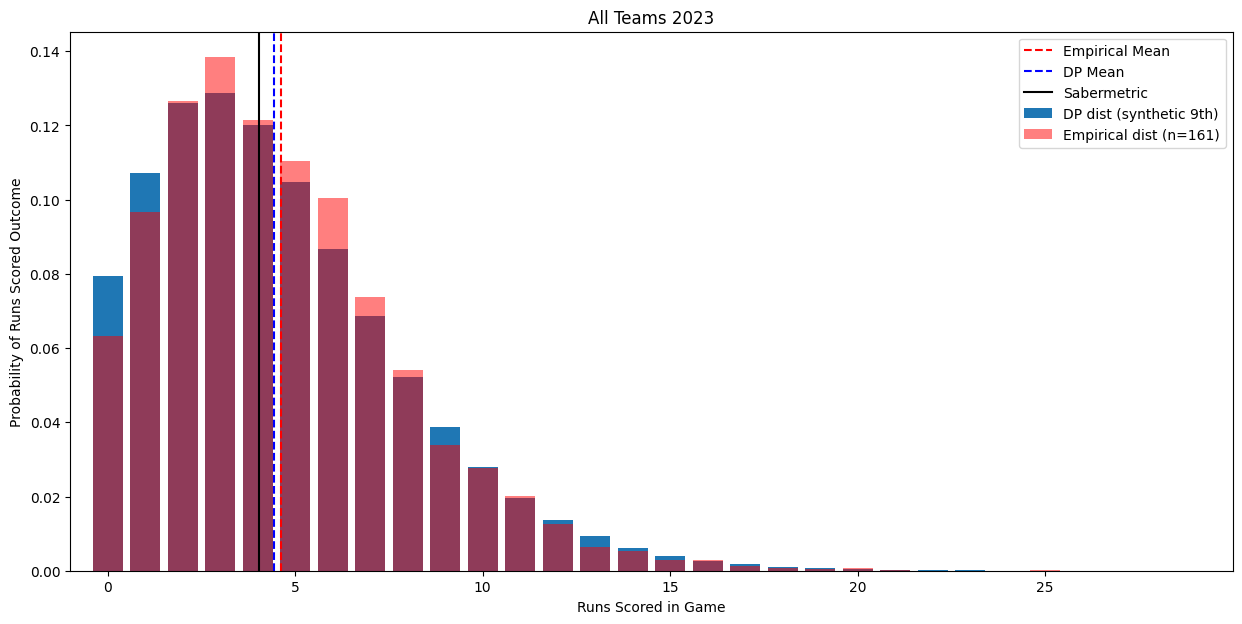

In [53]:
import matplotlib.pyplot as plt
from seaborn import histplot
import numpy as np
from collections import defaultdict
num_teams = len(dpdfnan.team.unique())

all_dp = pd.read_csv('v2_probs.csv',header=None)

all_scores = dpdfnan.groupby('team')['Score'].apply(lambda x: x[:-2]).explode().reset_index(drop=True)

fig, ax = plt.subplots(figsize=(15, 7))

x_positions = np.arange(0,41)
dps = []
sabers = []
dpdists = defaultdict(int)
for team in dpdfnan.team.unique():
  filtered_df = all_dp[all_dp[5] == team]
  sabers.append(dpdfnan[dpdfnan['team'] == team]['saber23'][:-2].mean())

  list_column_3 = filtered_df.iloc[0, 3].split(',')
  list_column_4 = filtered_df.iloc[0, 4].split(',')
  dps.append(float(filtered_df.iloc[0, 2]))

  list_column_3 = [int(num) for num in list_column_3]
  list_column_4 = [float(num) for num in list_column_4]
  for k, v in zip(list_column_3,list_column_4):
    dpdists[k] += v

  #ax.bar(list_column_3, list_column_4,label='DP dist (synthetic 9th)')
  #plt.hist(wsn_empirical, bins = int(wsn_empirical.max()), weights=np.ones(len(wsn_empirical)) / len(wsn_empirical),color='red',alpha=.5,label='Empirical distribution (n=161)')


ax.bar(dpdists.keys(),[v/len(dpdfnan.team.unique()) for v in dpdists.values()],label = 'DP dist (synthetic 9th)')

values, counts = np.unique(all_scores, return_counts=True)
percentages = counts / len(all_scores)
bar_counts = np.zeros(len(x_positions))
bar_counts[values.astype(int)] = percentages

ax.bar(x_positions, bar_counts, color='red', alpha=0.5, label='Empirical dist (n=161)')
ax.set_xticks(x_positions)
ax.set_xlim(-1, 30)
ax.set_xticks(np.arange(0, 30, 5))  # Set labels every 5
ax.set_xticklabels(np.arange(0, 30, 5))


ax.axvline(all_scores.mean(), color = 'red', ls='--',label='Empirical Mean')
ax.axvline(np.mean(dps), color = 'blue', ls='--', label='DP Mean')
ax.axvline(np.mean(sabers), color = 'black', ls = '-', label='Sabermetric')

ax.set_xlabel('Runs Scored in Game')
ax.set_ylabel('Probability of Runs Scored Outcome')
ax.set_title('All Teams 2023')
ax.legend()
#    ax.set_title(f'Team {team}')

plt.show()

In [55]:
#print(len(dpdists.keys()), len(dpdists.values()), len(bar_counts))
print_df = pd.DataFrame({'# of Runs Scored':dpdists.keys(),'DP Prob of Score':[v/len(dpdfnan.team.unique()) for v in dpdists.values()], 'Empirical Prob of Score': (bar_counts)})
print_df['Error'] = abs(print_df['Empirical Prob of Score'] - print_df['DP Prob of Score'])
pd.options.display.float_format = '{:20,.8f}'.format
print('Proportion of all games in 2023 ending with different runs scored, for DP vs. Empirical Distributions')

display(print_df)



Proportion of all games in 2023 ending with different runs scored, for DP vs. Empirical Distributions


,# of Runs Scored,DP Prob of Score,Empirical Prob of Score,Error
0,0,0.07954007,0.06333333,0.01620673
1,1,0.10717430,0.09666667,0.01050764
2,2,0.12594770,0.12645833,0.00051064
3,3,0.12863888,0.13833333,0.00969445
4,4,0.12003449,0.12145833,0.00142384
5,5,0.10474374,0.11041667,0.00567293
6,6,0.08665202,0.10041667,0.01376465
7,7,0.06856698,0.07375000,0.00518302
8,8,0.05227663,0.05395833,0.00168170
9,9,0.03865824,0.03375000,0.00490824


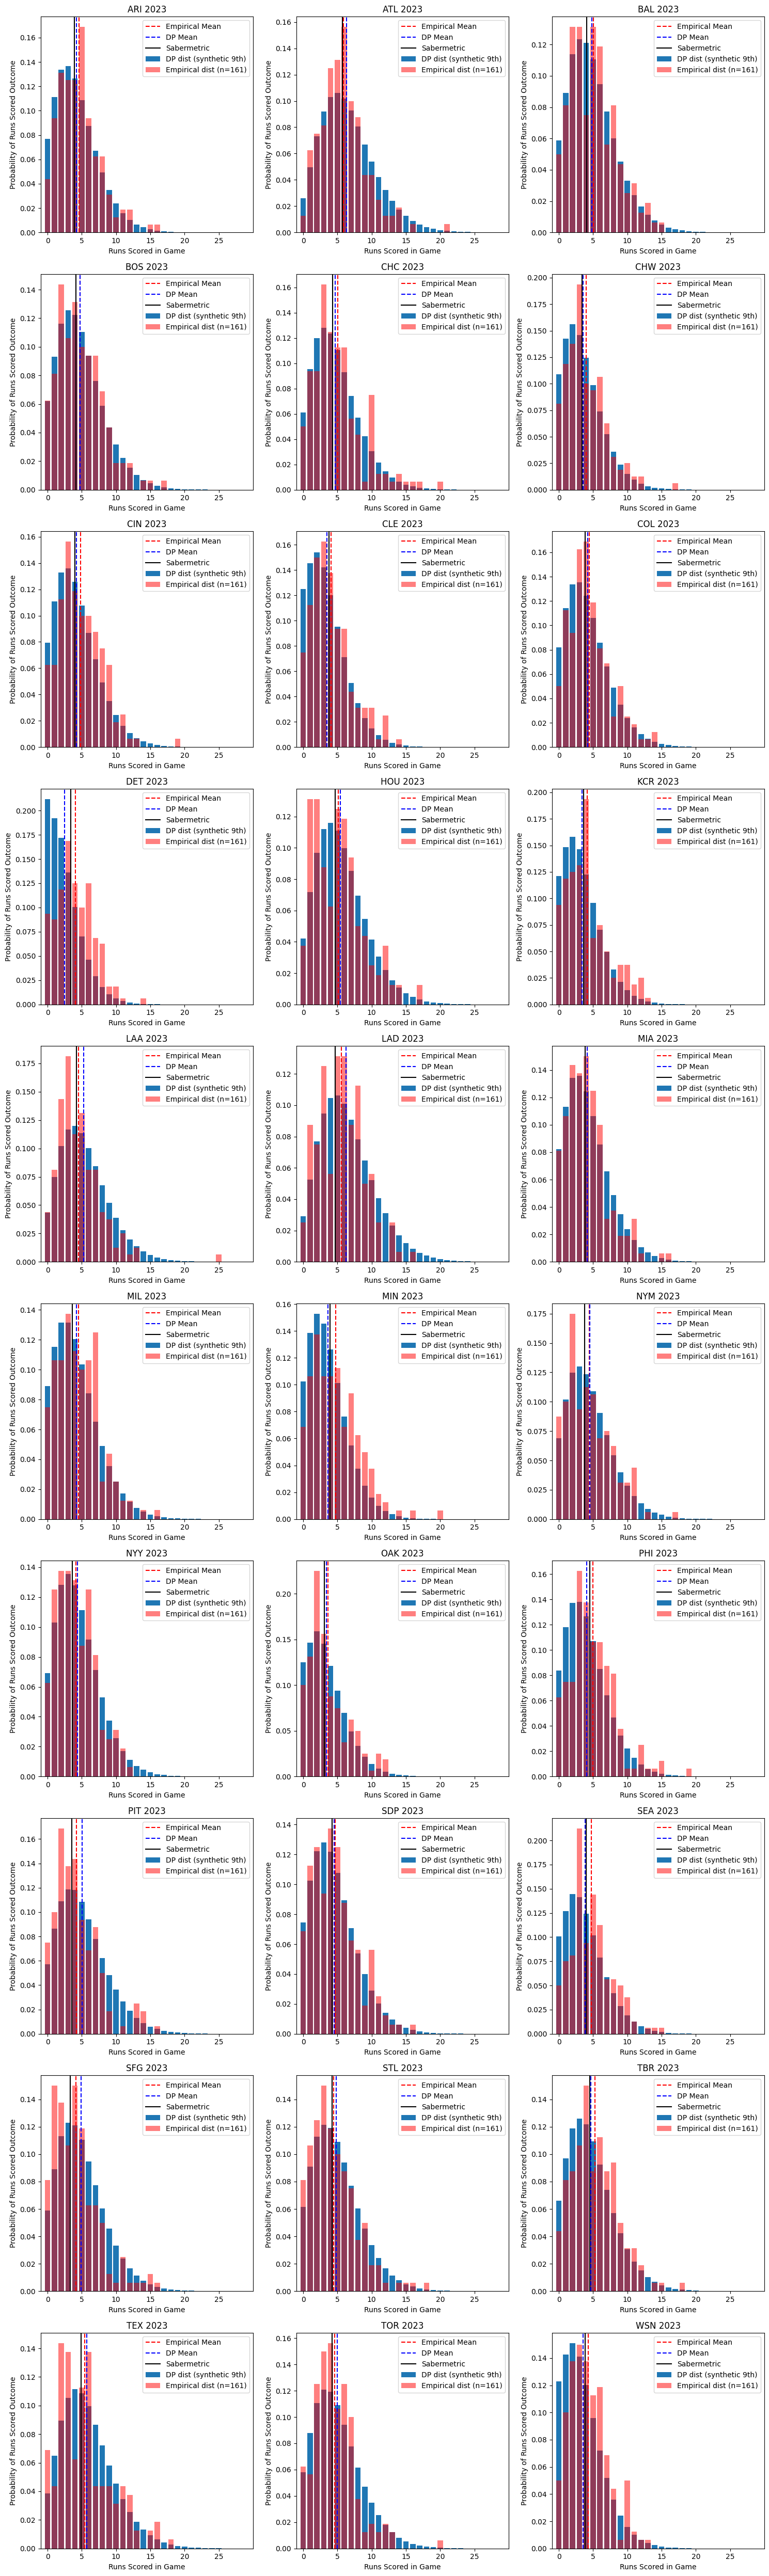

In [61]:
num_teams = len(dpdfnan.team.unique())
cols = 3
rows = (num_teams + cols - 1) // cols  # Compute number of rows needed

# Create a figure with subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()  # Flatten the 2D array of axes to make indexing easier
wsn_dp = pd.read_csv('../v2_probs.csv',header=None)
#print(wsn_dp.iloc[0,5])
runs = []
dps = []
emps = []
teams = []
for i, team in enumerate(dpdfnan.team.unique()):

      ax = axes[i]

      wsn_empirical = dpdfnan[dpdfnan['team'] == team]['Score'][:-2]

      filtered_df = wsn_dp[wsn_dp[5] == team]

      wsn_saber = dpdfnan[dpdfnan['team'] == team]['saber23'].mean()

      #list_column_3 = wsn_dp.iloc[wsn_dp[5] == team, 3].values[0].split(',')  # First row, first column
      list_column_3 = filtered_df.iloc[0, 3].split(',')
      #list_column_4 = wsn_dp.iloc[wsn_dp[5] == team, 4].split(',')  # First row, second column
      list_column_4 = filtered_df.iloc[0, 4].split(',')
      #dp = float(wsn_dp.iloc[wsn_dp[5] == team,2])
      dp = float(filtered_df.iloc[0, 2])
      #print(dp)


      list_column_3 = [int(num) for num in list_column_3]
      list_column_4 = [float(num) for num in list_column_4]

      ax.bar(list_column_3, list_column_4,label='DP dist (synthetic 9th)')
      #plt.hist(wsn_empirical, bins = int(wsn_empirical.max()), weights=np.ones(len(wsn_empirical)) / len(wsn_empirical),color='red',alpha=.5,label='Empirical distribution (n=161)')

      x_positions = np.arange(0, 40)
      values, counts = np.unique(wsn_empirical, return_counts=True)
      percentages = counts / len(wsn_empirical)
      bar_counts = np.zeros(len(x_positions))
      bar_counts[values.astype(int)] = percentages

      ax.bar(x_positions, bar_counts, color='red', alpha=0.5, label='Empirical dist (n=161)')
      ax.set_xticks(x_positions)
      ax.set_xlim(-1, 30)
      ax.set_xticks(np.arange(0, 30, 5))  # Set labels every 5
      ax.set_xticklabels(np.arange(0, 30, 5))


      ax.axvline(wsn_empirical.mean(), color = 'red', ls='--',label='Empirical Mean')
      ax.axvline(dp, color = 'blue', ls='--', label='DP Mean')
      ax.axvline(wsn_saber, color = 'black', ls = '-', label='Sabermetric')

      ax.set_xlabel('Runs Scored in Game')
      ax.set_ylabel('Probability of Runs Scored Outcome')
      ax.set_title(team + ' 2023')
      ax.legend()

      runs.append(np.arange(0,40))
      dps.append(list_column_4[:40])
      emps.append(bar_counts)
      teams.append(team)

# Hide unused subplots if there are fewer teams than the total number of subplots
for j in range(num_teams, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [66]:
#Tabulation team-wise
#df = pd.DataFrame({'Runs Scored': runs.flatten(), 'DP': dps.flatten(), 'Empirical': emps.flatten(), 'Team': teams})
df = pd.DataFrame({
    'Runs Scored': np.array(runs).flatten(),
    'DP': np.array(dps).flatten(),
    'Empirical': np.array(emps).flatten(),
    'Team': np.repeat(teams, len(runs[0]))  # Adjust to match the flattened length
})
df['Error'] = abs(df['Empirical'] - df['DP'])
pd.options.display.float_format = '{:20,.6f}'.format
print('Proportion of games ending with different runs scored for DP vs. Empirical Distributions')
display(df)

Proportion of games ending with different runs scored for DP vs. Empirical Distributions


,Runs Scored,DP,Empirical,Team,Error
0,0,0.076807,0.043750,ARI,0.033057
1,1,0.111008,0.093750,ARI,0.017258
2,2,0.133722,0.131250,ARI,0.002472
3,3,0.136780,0.125000,ARI,0.011780
4,4,0.126504,0.125000,ARI,0.001504
...,...,...,...,...,...
1195,35,0.000000,0.000000,WSN,0.000000
1196,36,0.000000,0.000000,WSN,0.000000
1197,37,0.000000,0.000000,WSN,0.000000
1198,38,0.000000,0.000000,WSN,0.000000


When calculating the possible game outcomes with DP, we only consider one subset of 9 players (where 8 are real players, chosen from the first game of season), and the 9th is a synthetic player meant to bring the 9-player batting lineup to the team season average.

However, this ordering is likely not optimal. When comparing the mean of all empirical scores on real-world games, vs. the mean of DP expected score computed on all real-world games, we find that DP and empirical have low MAE.

Below is another example (ATL 2023)

# A Zoomed-in Highlight of ATL

In [ ]:
team = 'ATL'
yr = 2023

input_df = fetch_batting_orders(team,yr)
stat_df = fetch_player_stats(team,yr)
process_output(stat_df,input_df)

<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


ATL


Text(0.5, 1.0, 'ATL 2023')

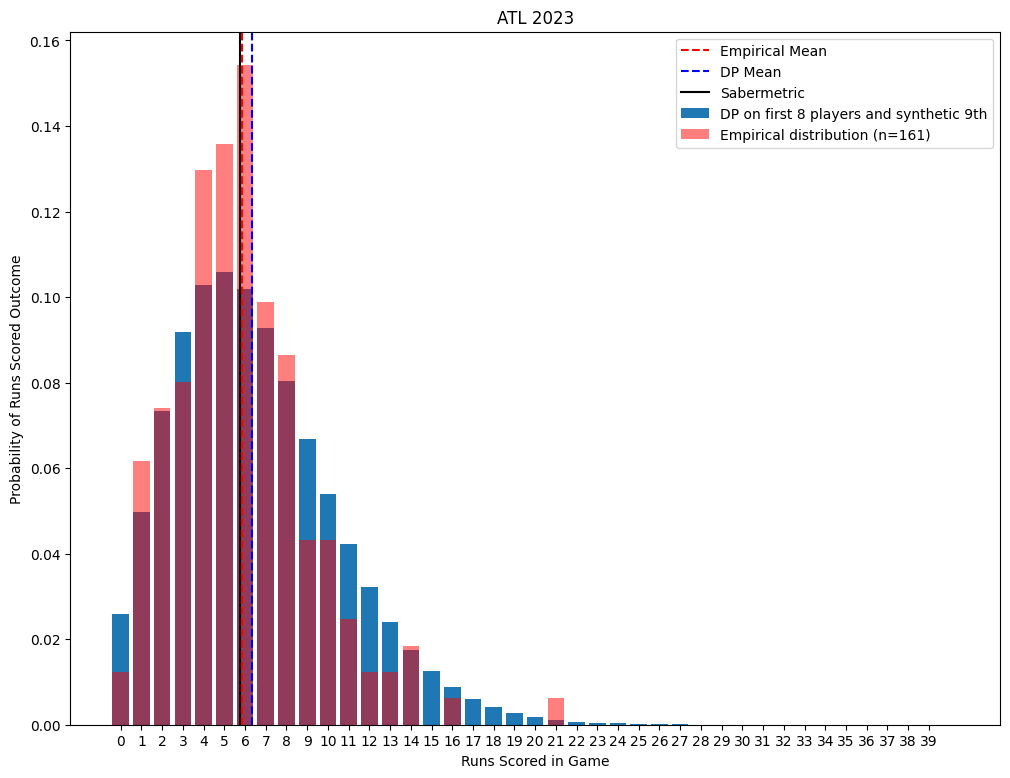

In [ ]:
wsn_empirical = pd.read_csv('output.csv')['Score'][:-2]

wsn_dp = pd.read_csv('v2_probs.csv',header=None)
print(wsn_dp.iloc[0,5])

list_column_3 = wsn_dp.iloc[0, 3].split(',')  # First row, first column
list_column_4 = wsn_dp.iloc[0, 4].split(',')  # First row, second column
dp = float(wsn_dp.iloc[0,2])

list_column_3 = [int(num) for num in list_column_3]
list_column_4 = [float(num) for num in list_column_4]
plt.figure(figsize=(12,9))
plt.bar(list_column_3, list_column_4,label='DP on first 8 players and synthetic 9th')
#plt.hist(wsn_empirical, bins = int(wsn_empirical.max()), weights=np.ones(len(wsn_empirical)) / len(wsn_empirical),color='red',alpha=.5,label='Empirical distribution (n=161)')

x_positions = np.arange(0, 40)
values, counts = np.unique(wsn_empirical, return_counts=True)
percentages = counts / len(wsn_empirical)
bar_counts = np.zeros(len(x_positions))
bar_counts[values.astype(int)] = percentages

plt.bar(x_positions, bar_counts, color='red', alpha=0.5, label='Empirical distribution (n=161)')
plt.xticks(x_positions)


plt.axvline(wsn_empirical.mean(), color = 'red', ls='--',label='Empirical Mean')
plt.axvline(dp, color = 'blue', ls='--', label='DP Mean')
plt.axvline(5.732590, color = 'black', ls = '-', label='Sabermetric')

plt.legend()
plt.xlabel('Runs Scored in Game')
plt.ylabel('Probability of Runs Scored Outcome')
plt.title(team + ' 2023')


In [ ]:
df = pd.DataFrame({'DP': list_column_4[:40], 'Empirical': bar_counts})
df['Error'] = abs(df['Empirical'] - df['DP'])
pd.options.display.float_format = '{:20,.6f}'.format
print('Proportion of games ending with different runs scored for DP vs. Empirical Distributions')
display(df)

Proportion of games ending with different runs scored for DP vs. Empirical Distributions


,DP,Empirical,Error
0,0.025878,0.012346,0.013533
1,0.049643,0.061728,0.012085
2,0.073281,0.074074,0.000793
3,0.091892,0.080247,0.011645
4,0.102904,0.129630,0.026725
5,0.105920,0.135802,0.029883
6,0.101946,0.154321,0.052375
7,0.092724,0.098765,0.006041
8,0.080392,0.086420,0.006028
9,0.066920,0.043210,0.023710


# Proof that DP and Simulation match: 2023 Red Sox batting avgs


In [ ]:
!julia main.jl redsox_2023.csv 4 7 3 2 9 1 8 5 6

Player batting probabilities all sum to 1
accepted batting lineup[4, 7, 3, 2, 9, 1, 8, 5, 6]
populating memo
  0.515292 seconds (913.75 k allocations: 45.446 MiB, 92.77% compilation time)
calculating expected runs
p(0) is 0.06335467282283026
p(1) is 0.09492857084728976
p(2) is 0.11776186497140737
p(3) is 0.12603903440538347
p(4) is 0.121749016406277
p(5) is 0.10939608609076235
p(6) is 0.09283852881568241
p(7) is 0.07501205566147555
p(8) is 0.05812921003438619
p(9) is 0.04340392478136401
p(10) is 0.03139013208792811
p(11) is 0.022089685505928026
p(12) is 0.01519095981800549
p(13) is 0.010241139936626939
p(14) is 0.006778697612757728
p(15) is 0.004407144678288749
p(16) is 0.00281384742333539
p(17) is 0.0017647239663086726
p(18) is 0.0010883495655138965
p(19) is 0.0006614055889739304
p(20) is 0.00039708543914248625
p(21) is 0.00023602863778220148
p(22) is 0.0001390597507922986
p(23) is 8.118968619189076e-5
p(24) is 4.692063610467783e-5
p(25) is 2.6806870088727633e-5
p(26) is 1.51328004342

In [ ]:
!julia plotpmf.jl

Expected Number (Mean): 4.841375056924311


In [ ]:
!julia plotquantile.jl

maxR = 40 by default


Plots

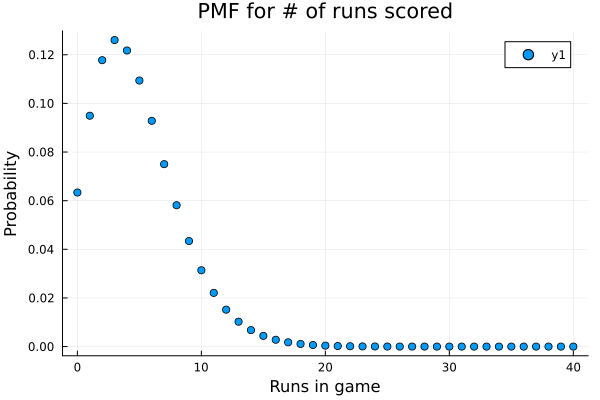

In [ ]:
from IPython.display import Image
Image(filename='pmf.png')


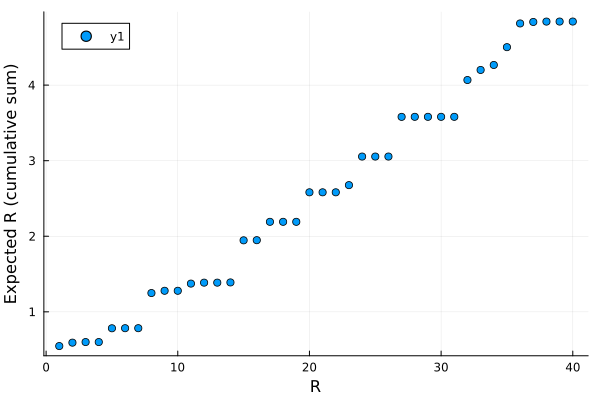

In [ ]:
from IPython.display import Image
Image(filename='quantile.png')


In [ ]:
!julia sim.jl redsox_2023.csv 1000000 4 7 3 2 9 1 8 5 6

Accepted batting lineup [4, 7, 3, 2, 9, 1, 8, 5, 6]
Comparison of DP vs. Simulated Summary Stats:
4×3 DataFrame
 Row │ Metric                  DP        Simulated 
     │ String                  Float64   Float64   
─────┼─────────────────────────────────────────────
   1 │ Expected Number (Mean)   4.84138    4.82632
   2 │ Standard Deviation       3.39297    3.39091
   3 │ Minimum                  0.0        0.0
   4 │ Maximum                 40.0       35.0

Comparison of DP vs. Simulated histograms:
4×2 DataFrame
 Row │ Metric       Value      
     │ String       Float64    
─────┼─────────────────────────
   1 │ Sum abs dif  0.00383621
   2 │ Sum sq dif   1.65474e-6
   3 │ Corr         0.999987
   4 │ Chi-square   3.84919e-5

Table of difference in Pr(r) (%) for DP - sim
32×2 DataFrame
 Row │ R      Difference   
     │ Int64  Float64      
─────┼─────────────────────
   1 │     0  -0.0799327
   2 │     1  -0.0377429
   3 │     2  -0.0700135
   4 │     3  -0.000796559
   5 │     4

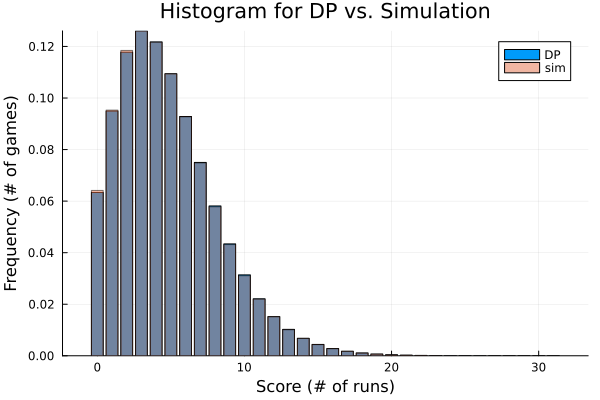

In [ ]:
from IPython.display import Image
Image(filename='histogram-comparison.png')


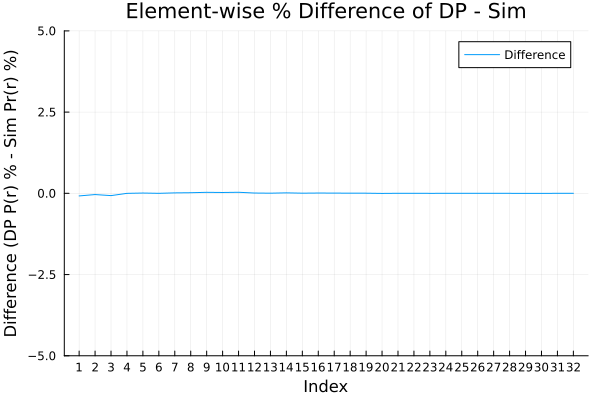

In [ ]:
from IPython.display import Image
Image(filename='dpsim-difference.png')
